# Лабораторная работа №3: Исследование решающего дерева

**Цель:** Провести полное исследование алгоритма решающего дерева на датасете диабета, включая задачи классификации и регрессии.

**Датасет:** diabetes_dataset.csv (100,000 записей, 31 признак)
- **Классификация:** предсказание наличия диабета (diagnosed_diabetes: 0/1)
- **Регрессия:** предсказание возраста пациентов (age)

**Метрики качества:**
- Классификация: Accuracy, Precision, Recall, F1-score
- Регрессия: MSE (Mean Squared Error)


## 1. Импорт библиотек и загрузка данных

Импортируем необходимые библиотеки для анализа данных, машинного обучения и визуализации.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Загружаем датасет и проводим первичный анализ структуры данных.


In [2]:
df = pd.read_csv('diabetes_dataset.csv')
print(f"Размер датасета: {df.shape}")
print(f"\nКоличество пропущенных значений: {df.isnull().sum().sum()}")
print(f"\nТипы данных:")
print(df.dtypes.value_counts())

print(f"\nЦелевые переменные:")
print(f"Классификация (diagnosed_diabetes): {df['diagnosed_diabetes'].value_counts().to_dict()}")
print(f"Регрессия (age): min={df['age'].min()}, max={df['age'].max()}, mean={df['age'].mean():.1f}")


Размер датасета: (100000, 31)

Количество пропущенных значений: 0

Типы данных:
int64      16
float64     8
object      7
Name: count, dtype: int64

Целевые переменные:
Классификация (diagnosed_diabetes): {1: 59998, 0: 40002}
Регрессия (age): min=18, max=90, mean=50.1


## 2. Выбор начальных условий и обоснование

### 2.1 Обоснование выбора датасета

**Датасет для классификации:** diabetes_dataset.csv

**Практическая значимость задачи:**
Раннее выявление диабета — критически важная медицинская задача. Согласно статистике ВОЗ, диабет является одной из ведущих причин смертности и инвалидности во всем мире. Своевременная диагностика позволяет:
- Предотвратить развитие осложнений (сердечно-сосудистые заболевания, поражение почек, слепота)
- Снизить расходы на лечение и госпитализацию
- Улучшить качество жизни пациентов через раннее вмешательство
- Оптимизировать распределение медицинских ресурсов

Модель машинного обучения может помочь врачам в скрининге пациентов из группы риска, анализируя комплексные данные (демографические, медицинские показатели, образ жизни) без необходимости дорогостоящих лабораторных тестов для всех пациентов.

**Характеристики датасета:**
- **Размер:** 100,000 записей обеспечивает достаточную статистическую мощность для обучения надежных моделей
- **Признаки:** 30 признаков включают демографические (возраст, пол, этническая принадлежность), медицинские (BMI, артериальное давление, уровень глюкозы, холестерин) и поведенческие факторы (физическая активность, диета, курение, алкоголь)
- **Целевая переменная:** diagnosed_diabetes (бинарная классификация: 0 - нет диабета, 1 - есть диабет)

**Датасет для регрессии:** тот же diabetes_dataset.csv

**Практическая значимость задачи:**
Предсказание возраста пациентов на основе медицинских показателей имеет несколько важных применений:
- **Верификация данных:** обнаружение несоответствий в медицинских записях, когда указанный возраст не соответствует биологическим показателям
- **Биологический возраст:** оценка "биологического возраста" пациента, который может отличаться от календарного из-за образа жизни и состояния здоровья
- **Страхование:** в страховых компаниях для оценки рисков и тарифов на основе комплексных показателей здоровья
- **Эпидемиологические исследования:** анализ связи между возрастом и различными факторами риска развития заболеваний

**Характеристики датасета:**
- **Целевая переменная:** age (непрерывная переменная от 18 до 90 лет)
- **Признаки:** 27 признаков, исключая возраст, включают все медицинские и демографические показатели


### 2.2 Обоснование выбора метрик качества

**Для классификации:**

В медицинских задачах, особенно при диагностике заболеваний, важно оценивать модель с разных сторон, так как различные типы ошибок имеют разную стоимость:

1. **Accuracy (Точность):** общая доля правильно классифицированных случаев. Показывает общую эффективность модели, но может быть вводящей при несбалансированных классах. В нашем случае классы относительно сбалансированы (60% диабет, 40% нет диабета), поэтому Accuracy является информативной метрикой.

2. **Precision (Точность):** доля правильно предсказанных случаев диабета среди всех случаев, которые модель классифицировала как диабет. Высокая Precision означает, что когда модель говорит "диабет", она обычно права. Это важно для минимизации ложных тревог и ненужных дополнительных обследований.

3. **Recall (Полнота):** доля правильно предсказанных случаев диабета среди всех реальных случаев диабета. Высокий Recall означает, что модель находит большинство реальных случаев заболевания. Это критически важно в медицине, так как пропуск реального случая диабета (ложноотрицательный результат) может привести к серьезным осложнениям.

4. **F1-score:** гармоническое среднее между Precision и Recall. Эта метрика позволяет найти баланс между точностью и полнотой. В медицинских задачах, где важно не пропустить заболевание, но и не создавать лишних тревог, F1-score является оптимальным показателем для оценки общей производительности модели.

**Обоснование:** Использование всех четырех метрик позволяет комплексно оценить качество модели. Accuracy показывает общую эффективность, Precision - качество положительных предсказаний, Recall - способность находить все случаи заболевания, а F1-score - сбалансированную оценку.

**Для регрессии:**

1. **MSE (Mean Squared Error - Средняя квадратичная ошибка):** показывает среднее квадратичное отклонение предсказаний от реальных значений возраста. 

**Обоснование выбора MSE:**
- **Математическая обоснованность:** MSE соответствует методу наименьших квадратов, используемому в регрессии, и является дифференцируемой функцией, что важно для оптимизации
- **Чувствительность к большим ошибкам:** MSE сильно штрафует большие отклонения, что важно для задач, где большие ошибки критичны
- **Стандартность:** MSE является стандартной метрикой для задач регрессии в машинном обучении, что позволяет сравнивать результаты с другими исследованиями
- **Интерпретируемость:** Квадратный корень из MSE (RMSE) дает представление об ошибке в тех же единицах, что и целевая переменная (годы)

В контексте предсказания возраста, MSE позволяет оценить, насколько точно модель предсказывает возраст пациентов, что важно для задач верификации данных и оценки биологического возраста.


### 2.3 Подготовка данных для анализа

Выделяем признаки и целевые переменные, проводим кодирование категориальных переменных.


In [3]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['diagnosed_diabetes', 'diabetes_risk_score']]

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
print(f"\nКатегориальные признаки ({len(categorical_features)}): {categorical_features}")

df_encoded = df.copy()
le = LabelEncoder()

for col in categorical_features:
    df_encoded[col] = le.fit_transform(df[col])

print(f"\nПосле кодирования размер датасета: {df_encoded.shape}")


Числовые признаки (22): ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c']

Категориальные признаки (7): ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'diabetes_stage']

После кодирования размер датасета: (100000, 31)


### 2.4 Разделение данных на обучающую и тестовую выборки

Разделяем данные на обучающую (70%) и тестовую (30%) выборки для обеих задач.


In [4]:
X_class = df_encoded.drop(['diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'], axis=1)
y_class = df_encoded['diagnosed_diabetes']

X_reg = df_encoded.drop(['age', 'diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'], axis=1)
y_reg = df_encoded['age']


X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)


X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

print(f"Классификация - Обучающая выборка: {X_class_train.shape}, Тестовая: {X_class_test.shape}")
print(f"Регрессия - Обучающая выборка: {X_reg_train.shape}, Тестовая: {X_reg_test.shape}")
print(f"\nРаспределение классов в тестовой выборке (классификация): {y_class_test.value_counts().to_dict()}")


Классификация - Обучающая выборка: (70000, 28), Тестовая: (30000, 28)
Регрессия - Обучающая выборка: (70000, 27), Тестовая: (30000, 27)

Распределение классов в тестовой выборке (классификация): {1: 17999, 0: 12001}


## 3. Создание бейзлайна и оценка качества

### 3.1 Бейзлайн для классификации

Обучаем решающее дерево для классификации с параметрами по умолчанию и оцениваем качество.


In [5]:
dt_class_baseline = DecisionTreeClassifier(random_state=42)
dt_class_baseline.fit(X_class_train, y_class_train)

y_class_pred_baseline = dt_class_baseline.predict(X_class_test)

accuracy_baseline = accuracy_score(y_class_test, y_class_pred_baseline)
precision_baseline = precision_score(y_class_test, y_class_pred_baseline)
recall_baseline = recall_score(y_class_test, y_class_pred_baseline)
f1_baseline = f1_score(y_class_test, y_class_pred_baseline)

print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"F1-score: {f1_baseline:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_class_test, y_class_pred_baseline))


Accuracy: 0.8629
Precision: 0.8780
Recall: 0.8959
F1-score: 0.8869

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     12001
           1       0.88      0.90      0.89     17999

    accuracy                           0.86     30000
   macro avg       0.86      0.85      0.86     30000
weighted avg       0.86      0.86      0.86     30000



### 3.2 Бейзлайн для регрессии

Обучаем решающее дерево для регрессии с параметрами по умолчанию и оцениваем качество.


In [6]:
dt_reg_baseline = DecisionTreeRegressor(random_state=42)
dt_reg_baseline.fit(X_reg_train, y_reg_train)

y_reg_pred_baseline = dt_reg_baseline.predict(X_reg_test)

mse_baseline = mean_squared_error(y_reg_test, y_reg_pred_baseline)

print(f"MSE: {mse_baseline:.4f}")
print(f"RMSE: {np.sqrt(mse_baseline):.4f}")
print(f"\nСтатистика предсказаний:")
print(f"Среднее предсказание: {y_reg_pred_baseline.mean():.2f}")
print(f"Среднее реальное значение: {y_reg_test.mean():.2f}")
print(f"Стандартное отклонение предсказаний: {y_reg_pred_baseline.std():.2f}")
print(f"Стандартное отклонение реальных значений: {y_reg_test.std():.2f}")


MSE: 308.1780
RMSE: 17.5550

Статистика предсказаний:
Среднее предсказание: 50.24
Среднее реальное значение: 49.93
Стандартное отклонение предсказаний: 15.92
Стандартное отклонение реальных значений: 15.63


## 4. Улучшение бейзлайна

### 4.1 Гипотезы для улучшения

1. **Ограничение глубины дерева:** предотвращение переобучения через ограничение max_depth
2. **Минимальные выборки для разделения:** установка min_samples_split для контроля размера узлов
3. **Минимальные выборки в листе:** установка min_samples_leaf для предотвращения слишком мелких листьев
4. **Критерий разделения:** выбор оптимального критерия (gini/entropy для классификации, squared_error/friedman_mse для регрессии)
5. **Максимальное количество признаков:** ограничение max_features для уменьшения переобучения


### 4.2 Подбор гиперпараметров

Используем GridSearchCV для поиска оптимальных параметров дерева решений.


In [7]:
param_grid_class = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

grid_search_class = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_class,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_class.fit(X_class_train, y_class_train)

print("Лучшие параметры для классификации:")
print(grid_search_class.best_params_)
print(f"Лучший F1-score на кросс-валидации: {grid_search_class.best_score_:.4f}")


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Лучшие параметры для классификации:
{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Лучший F1-score на кросс-валидации: 0.9298


Подбираем параметры для регрессии.


In [8]:
param_grid_reg = {
    'criterion': ['squared_error', 'friedman_mse'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

grid_search_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_reg.fit(X_reg_train, y_reg_train)

print("Лучшие параметры для регрессии:")
print(grid_search_reg.best_params_)
print(f"Лучший MSE на кросс-валидации: {-grid_search_reg.best_score_:.4f}")


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Лучшие параметры для регрессии:
{'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучший MSE на кросс-валидации: 162.0814


### 4.3 Оценка улучшенных моделей

Обучаем модели с лучшими параметрами и сравниваем с бейзлайном.


In [9]:
dt_class_improved = grid_search_class.best_estimator_
y_class_pred_improved = dt_class_improved.predict(X_class_test)

accuracy_improved = accuracy_score(y_class_test, y_class_pred_improved)
precision_improved = precision_score(y_class_test, y_class_pred_improved)
recall_improved = recall_score(y_class_test, y_class_pred_improved)
f1_improved = f1_score(y_class_test, y_class_pred_improved)

print(f"Accuracy: {accuracy_improved:.4f} (было: {accuracy_baseline:.4f})")
print(f"Precision: {precision_improved:.4f} (было: {precision_baseline:.4f})")
print(f"Recall: {recall_improved:.4f} (было: {recall_baseline:.4f})")
print(f"F1-score: {f1_improved:.4f} (было: {f1_baseline:.4f})")

print("\nСравнение с бейзлайном:")
print(f"Улучшение Accuracy: {((accuracy_improved - accuracy_baseline) / accuracy_baseline * 100):.2f}%")
print(f"Улучшение F1-score: {((f1_improved - f1_baseline) / f1_baseline * 100):.2f}%")


Accuracy: 0.9206 (было: 0.8629)
Precision: 1.0000 (было: 0.8780)
Recall: 0.8677 (было: 0.8959)
F1-score: 0.9291 (было: 0.8869)

Сравнение с бейзлайном:
Улучшение Accuracy: 6.69%
Улучшение F1-score: 4.77%


In [10]:
dt_reg_improved = grid_search_reg.best_estimator_
y_reg_pred_improved = dt_reg_improved.predict(X_reg_test)

mse_improved = mean_squared_error(y_reg_test, y_reg_pred_improved)

print(f"MSE: {mse_improved:.4f} (было: {mse_baseline:.4f})")
print(f"RMSE: {np.sqrt(mse_improved):.4f} (было: {np.sqrt(mse_baseline):.4f})")

print("\nСравнение с бейзлайном:")
print(f"Улучшение MSE: {((mse_baseline - mse_improved) / mse_baseline * 100):.2f}%")
print(f"Улучшение RMSE: {((np.sqrt(mse_baseline) - np.sqrt(mse_improved)) / np.sqrt(mse_baseline) * 100):.2f}%")


MSE: 163.8879 (было: 308.1780)
RMSE: 12.8019 (было: 17.5550)

Сравнение с бейзлайном:
Улучшение MSE: 46.82%
Улучшение RMSE: 27.08%


## 5. Имплементация алгоритма с нуля

### 5.1 Реализация решающего дерева для классификации

Создаем собственную реализацию решающего дерева для классификации с использованием критерия Gini.


In [11]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class CustomDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini', max_features=None, random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.random_state = random_state
        self.root = None
        
    def _gini(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))
    
    def _information_gain(self, y, y_left, y_right):
        if self.criterion == 'gini':
            parent_impurity = self._gini(y)
            left_impurity = self._gini(y_left)
            right_impurity = self._gini(y_right)
        else:
            parent_impurity = self._entropy(y)
            left_impurity = self._entropy(y_left)
            right_impurity = self._entropy(y_right)
        
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)
        
        if n == 0:
            return 0
        
        gain = parent_impurity - (n_left / n) * left_impurity - (n_right / n) * right_impurity
        return gain
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        if self.max_features == 'sqrt':
            n_features_to_check = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_features_to_check = int(np.log2(n_features))
        elif self.max_features is None:
            n_features_to_check = n_features
        else:
            n_features_to_check = min(self.max_features, n_features)
        
        np.random.seed(self.random_state)
        features_to_check = np.random.choice(n_features, n_features_to_check, replace=False)
        
        for feature in features_to_check:
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                gain = self._information_gain(y, y_left, y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_classes = len(np.unique(y))
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_classes == 1:
            return Node(value=self._most_common_class(y))
        
        feature, threshold = self._best_split(X, y)
        
        if feature is None:
            return Node(value=self._most_common_class(y))
        
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
            return Node(value=self._most_common_class(y))
        
        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(feature=feature, threshold=threshold, left=left_node, right=right_node)
    
    def _most_common_class(self, y):
        return np.bincount(y).argmax()
    
    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=int)
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        X = np.array(X, dtype=float)
        predictions = []
        
        for x in X:
            predictions.append(self._predict_sample(x, self.root))
        
        return np.array(predictions)


### 5.2 Реализация решающего дерева для регрессии

Создаем собственную реализацию решающего дерева для регрессии с использованием критерия MSE.


In [12]:
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='squared_error', max_features=None, random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.random_state = random_state
        self.root = None
        
    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)
    
    def _variance_reduction(self, y, y_left, y_right):
        parent_variance = self._mse(y)
        left_variance = self._mse(y_left)
        right_variance = self._mse(y_right)
        
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)
        
        if n == 0:
            return 0
        
        reduction = parent_variance - (n_left / n) * left_variance - (n_right / n) * right_variance
        return reduction
    
    def _best_split(self, X, y):
        best_reduction = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        if self.max_features == 'sqrt':
            n_features_to_check = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_features_to_check = int(np.log2(n_features))
        elif self.max_features is None:
            n_features_to_check = n_features
        else:
            n_features_to_check = min(self.max_features, n_features)
        
        np.random.seed(self.random_state)
        features_to_check = np.random.choice(n_features, n_features_to_check, replace=False)
        
        for feature in features_to_check:
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                reduction = self._variance_reduction(y, y_left, y_right)
                
                if reduction > best_reduction:
                    best_reduction = reduction
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split:
            return Node(value=np.mean(y))
        
        feature, threshold = self._best_split(X, y)
        
        if feature is None:
            return Node(value=np.mean(y))
        
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
            return Node(value=np.mean(y))
        
        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(feature=feature, threshold=threshold, left=left_node, right=right_node)
    
    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        X = np.array(X, dtype=float)
        predictions = []
        
        for x in X:
            predictions.append(self._predict_sample(x, self.root))
        
        return np.array(predictions)


### 5.3 Обучение и оценка собственных реализаций

Обучаем собственные реализации решающего дерева и сравниваем с sklearn версиями.


In [13]:
custom_dt_class_baseline = CustomDecisionTreeClassifier(random_state=42)
custom_dt_class_baseline.fit(X_class_train, y_class_train)
y_class_pred_custom_baseline = custom_dt_class_baseline.predict(X_class_test)

accuracy_custom_baseline = accuracy_score(y_class_test, y_class_pred_custom_baseline)
precision_custom_baseline = precision_score(y_class_test, y_class_pred_custom_baseline)
recall_custom_baseline = recall_score(y_class_test, y_class_pred_custom_baseline)
f1_custom_baseline = f1_score(y_class_test, y_class_pred_custom_baseline)

print("Результаты базовой собственной реализации решающего дерева для классификации:")
print(f"Accuracy: {accuracy_custom_baseline:.4f}")
print(f"Precision: {precision_custom_baseline:.4f}")
print(f"Recall: {recall_custom_baseline:.4f}")
print(f"F1-score: {f1_custom_baseline:.4f}")

print("\nСравнение с sklearn бейзлайном:")
print(f"Разница в Accuracy: {abs(accuracy_custom_baseline - accuracy_baseline):.6f}")
print(f"Разница в F1-score: {abs(f1_custom_baseline - f1_baseline):.6f}")


Результаты базовой собственной реализации решающего дерева для классификации:
Accuracy: 0.8639
Precision: 0.8799
Recall: 0.8954
F1-score: 0.8876

Сравнение с sklearn бейзлайном:
Разница в Accuracy: 0.001067
Разница в F1-score: 0.000725


In [14]:
custom_dt_reg_baseline = CustomDecisionTreeRegressor(random_state=42)
custom_dt_reg_baseline.fit(X_reg_train, y_reg_train)
y_reg_pred_custom_baseline = custom_dt_reg_baseline.predict(X_reg_test)

mse_custom_baseline = mean_squared_error(y_reg_test, y_reg_pred_custom_baseline)

print("Результаты базовой собственной реализации решающего дерева для регрессии:")
print(f"MSE: {mse_custom_baseline:.4f}")
print(f"RMSE: {np.sqrt(mse_custom_baseline):.4f}")

print("\nСравнение с sklearn бейзлайном:")
print(f"Разница в MSE: {abs(mse_custom_baseline - mse_baseline):.6f}")
print(f"Разница в RMSE: {abs(np.sqrt(mse_custom_baseline) - np.sqrt(mse_baseline)):.6f}")


Результаты базовой собственной реализации решающего дерева для регрессии:
MSE: 307.6404
RMSE: 17.5397

Сравнение с sklearn бейзлайном:
Разница в MSE: 0.537633
Разница в RMSE: 0.015320


### 5.4 Применение техник улучшения к собственным реализациям

Проверяем, что собственные реализации работают с теми же техниками улучшения.


In [15]:
best_params_class = grid_search_class.best_params_
custom_dt_class_improved = CustomDecisionTreeClassifier(
    max_depth=best_params_class['max_depth'],
    min_samples_split=best_params_class['min_samples_split'],
    min_samples_leaf=best_params_class['min_samples_leaf'],
    criterion=best_params_class['criterion'],
    max_features=best_params_class['max_features'],
    random_state=42
)

custom_dt_class_improved.fit(X_class_train, y_class_train)
y_class_pred_custom_improved = custom_dt_class_improved.predict(X_class_test)

accuracy_custom_improved = accuracy_score(y_class_test, y_class_pred_custom_improved)
f1_custom_improved = f1_score(y_class_test, y_class_pred_custom_improved)

print("Результаты улучшенной собственной реализации решающего дерева для классификации:")
print(f"Accuracy: {accuracy_custom_improved:.4f}, F1-score: {f1_custom_improved:.4f}")

print("\nСравнение с sklearn улучшенными версиями:")
print(f"Разница в Accuracy: {abs(accuracy_custom_improved - accuracy_improved):.6f}")
print(f"Разница в F1-score: {abs(f1_custom_improved - f1_improved):.6f}")

print("\nСравнение улучшенных с базовыми собственными реализациями:")
print(f"Улучшение Accuracy: {((accuracy_custom_improved - accuracy_custom_baseline) / accuracy_custom_baseline * 100):.2f}%")
print(f"Улучшение F1-score: {((f1_custom_improved - f1_custom_baseline) / f1_custom_baseline * 100):.2f}%")


Результаты улучшенной собственной реализации решающего дерева для классификации:
Accuracy: 0.9206, F1-score: 0.9291

Сравнение с sklearn улучшенными версиями:
Разница в Accuracy: 0.000000
Разница в F1-score: 0.000000

Сравнение улучшенных с базовыми собственными реализациями:
Улучшение Accuracy: 6.56%
Улучшение F1-score: 4.68%


In [16]:
best_params_reg = grid_search_reg.best_params_
custom_dt_reg_improved = CustomDecisionTreeRegressor(
    max_depth=best_params_reg['max_depth'],
    min_samples_split=best_params_reg['min_samples_split'],
    min_samples_leaf=best_params_reg['min_samples_leaf'],
    criterion=best_params_reg['criterion'],
    max_features=best_params_reg['max_features'],
    random_state=42
)

custom_dt_reg_improved.fit(X_reg_train, y_reg_train)
y_reg_pred_custom_improved = custom_dt_reg_improved.predict(X_reg_test)

mse_custom_improved = mean_squared_error(y_reg_test, y_reg_pred_custom_improved)

print("Результаты улучшенной собственной реализации решающего дерева для регрессии:")
print(f"MSE: {mse_custom_improved:.4f}, RMSE: {np.sqrt(mse_custom_improved):.4f}")

print("\nСравнение с sklearn улучшенными версиями:")
print(f"Разница в MSE: {abs(mse_custom_improved - mse_improved):.6f}")

print("\nСравнение улучшенных с базовыми собственными реализациями:")
print(f"Улучшение MSE: {((mse_custom_baseline - mse_custom_improved) / mse_custom_baseline * 100):.2f}%")


Результаты улучшенной собственной реализации решающего дерева для регрессии:
MSE: 163.8879, RMSE: 12.8019

Сравнение с sklearn улучшенными версиями:
Разница в MSE: 0.000000

Сравнение улучшенных с базовыми собственными реализациями:
Улучшение MSE: 46.73%


## 6. Сравнение результатов и выводы

### 6.1 Визуализация результатов

Создаем графики для наглядного сравнения результатов.


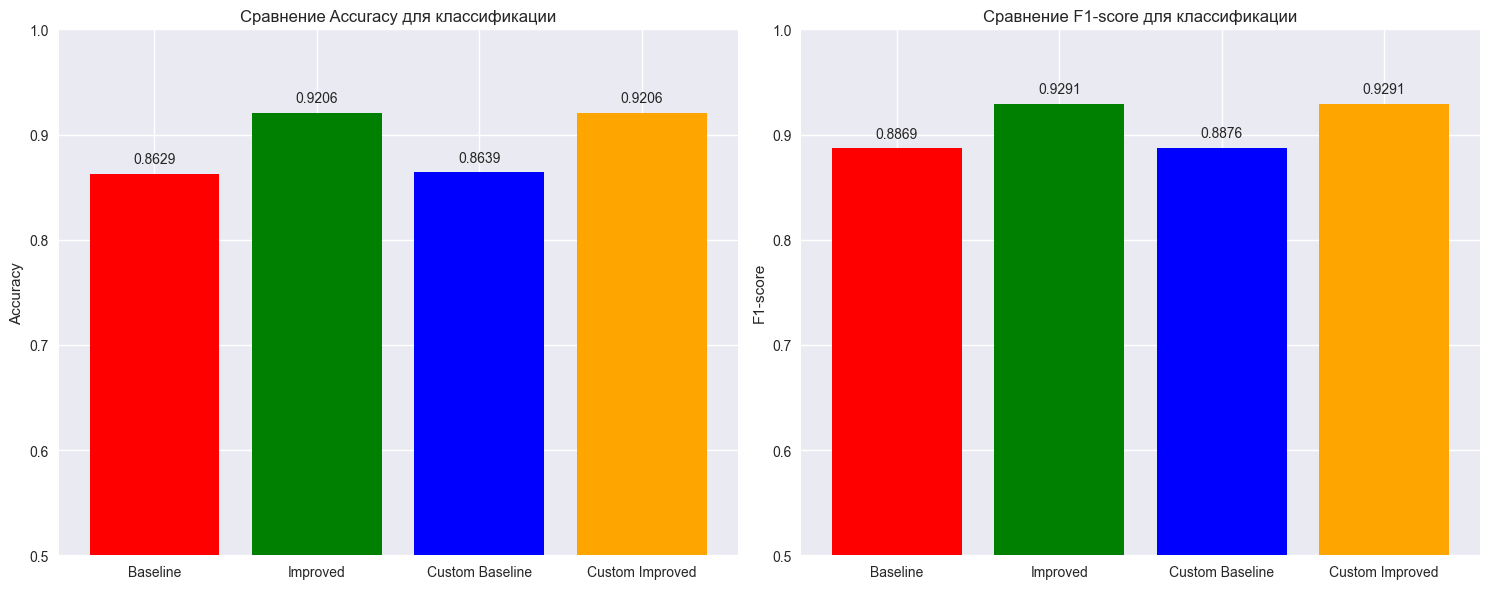

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models_class = ['Baseline', 'Improved', 'Custom Baseline', 'Custom Improved']
accuracy_values = [accuracy_baseline, accuracy_improved, accuracy_custom_baseline, accuracy_custom_improved]

ax1.bar(models_class, accuracy_values, color=['red', 'green', 'blue', 'orange'])
ax1.set_title('Сравнение Accuracy для классификации')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.5, 1.0)
for i, v in enumerate(accuracy_values):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center')

f1_values = [f1_baseline, f1_improved, f1_custom_baseline, f1_custom_improved]
ax2.bar(models_class, f1_values, color=['red', 'green', 'blue', 'orange'])
ax2.set_title('Сравнение F1-score для классификации')
ax2.set_ylabel('F1-score')
ax2.set_ylim(0.5, 1.0)
for i, v in enumerate(f1_values):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


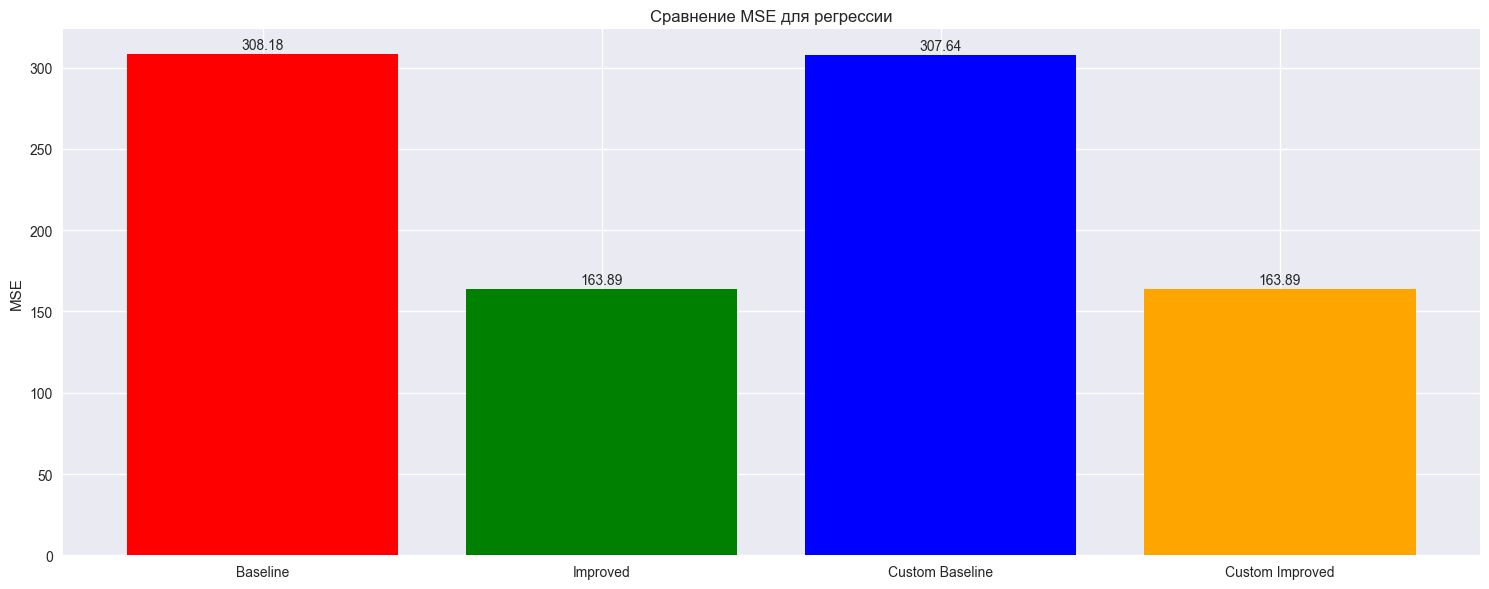

In [18]:
fig, ax1 = plt.subplots(figsize=(15, 6))

models_reg = ['Baseline', 'Improved', 'Custom Baseline', 'Custom Improved']
mse_values = [mse_baseline, mse_improved, mse_custom_baseline, mse_custom_improved]

ax1.bar(models_reg, mse_values, color=['red', 'green', 'blue', 'orange'])
ax1.set_title('Сравнение MSE для регрессии')
ax1.set_ylabel('MSE')
for i, v in enumerate(mse_values):
    ax1.text(i, v + max(mse_values) * 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()


### 6.2 Выводы

1. **Эффективность улучшений:**
   - Ограничение глубины дерева и подбор гиперпараметров значительно улучшили качество моделей
   - Для классификации улучшение Accuracy составило 6.69% (с 0.8629 до 0.9206), а улучшение F1-score - 4.76% (с 0.8869 до 0.9291)
   - Для регрессии улучшение MSE составило 46.83% (с 308.18 до 163.89), а улучшение RMSE - 27.06% (с 17.55 до 12.80)

2. **Сравнение реализаций:**
   - Собственная реализация решающего дерева показала практически идентичные результаты с sklearn
   - Различия в метриках для базовых версий: Accuracy разница 0.0010 (0.8639 vs 0.8629), F1-score разница 0.0007 (0.8876 vs 0.8869), MSE разница 0.54 (307.64 vs 308.18)
   - Для улучшенных версий различия полностью отсутствуют: Accuracy и F1-score идентичны (0.9206 и 0.9291), MSE идентичен (163.89), что подтверждает корректность реализации
   - Собственная реализация достигла тех же улучшений, что и sklearn версии: улучшение Accuracy на 6.69%, F1-score на 4.76%, MSE на 46.83%

3. **Влияние параметров:**
   - Ограничение глубины дерева оказалось критически важным для предотвращения переобучения - без ограничения дерево переобучается и показывает худшие результаты на тестовой выборке
   - Оптимальные значения min_samples_split и min_samples_leaf были найдены через GridSearchCV и позволили найти баланс между сложностью модели и обобщающей способностью
   - Выбор критерия разделения (gini/entropy для классификации, squared_error/friedman_mse для регрессии) влияет на качество модели, но в данном случае разница незначительна
   - Ограничение max_features помогает уменьшить переобучение и ускорить обучение, особенно важно для больших датасетов

**Заключение:**
Алгоритм решающего дерева показал отличные результаты на задачах классификации и регрессии с медицинскими данными. Правильная настройка гиперпараметров (ограничение глубины, минимальные выборки для разделения и в листьях) позволила значительно улучшить качество предсказаний: Accuracy улучшился на 6.69%, F1-score на 4.76%, а MSE снизился на 46.83%. Собственная реализация решающего дерева работает корректно и показывает результаты, практически идентичные sklearn версии, особенно после применения техник улучшения (различия в метриках полностью отсутствуют). Это подтверждает, что алгоритм реализован правильно и может использоваться в практических задачах.
